Coordinates of all points:
(-83.26, 9.48)
(-84.0, 9.02)
(-83.46, 8.68)
(-82.98, 8.44)
(-82.3, 9.96)
(-81.32, 7.28)
(-80.48, 6.64)
(-79.0, 6.01)
(-76.44, 5.58)
(-75.1, 5.93)
(-74.69, 4.99)
(-73.88, 4.32)
(-73.11, 3.88)
(-84.4, 4.22)
(-84.0, 4.5)
(-83.8, 4.8)
(-83.0, 5.0)
(-82.5, 5.2)
(-82.0, 5.02)
(-81.88, 5.5)
(-80.0, 5.4)
                                            geometry
0  LINESTRING (-83.26000 9.48000, -84.00000 9.020...
1  LINESTRING (-84.40000 4.22000, -84.00000 4.500...


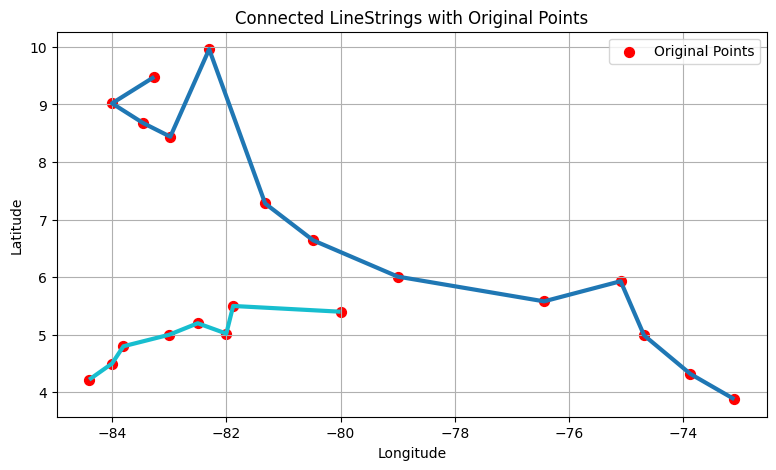

Shapefile saved at: lines.shp


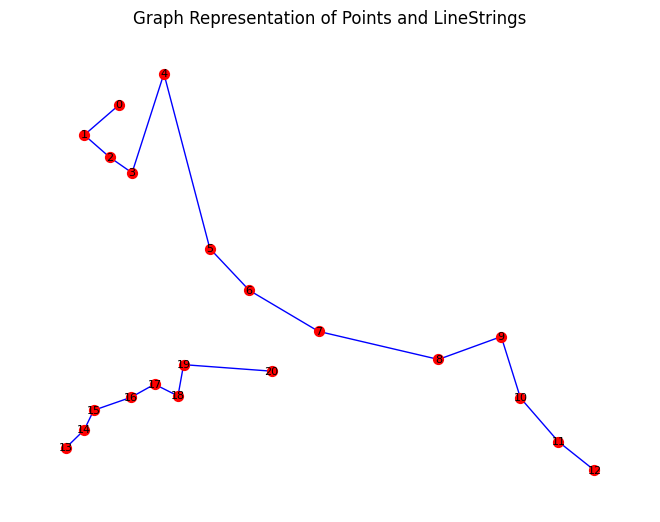

Shortest path between the given points: [8, 7, 20, 19, 18]
Weights of edges along the route:
Edge from 8 to 7 with weight 2.5958620918685207
Edge from 7 to 20 with weight 1.171366723105962
Edge from 20 to 19 with weight 1.8826576959181887
Edge from 19 to 18 with weight 0.49477267507412076
Total weight along the route: 6.144659185966792


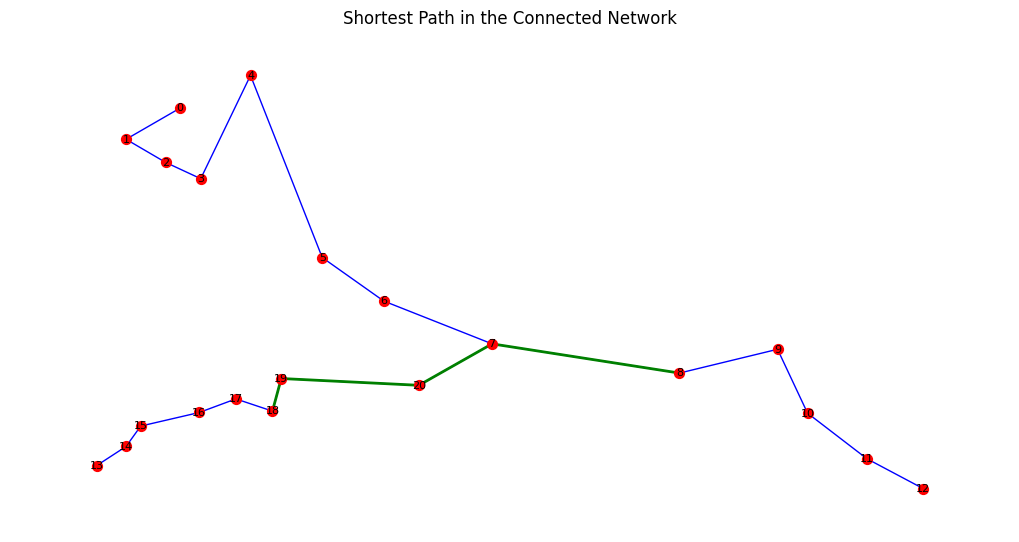

In [9]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import euclidean

# Read the CSV file into a DataFrame
xy_df = pd.read_csv('new_points.csv')
gdf = gpd.GeoDataFrame(xy_df, geometry=gpd.points_from_xy(xy_df.X, xy_df.Y), crs="EPSG:4326")

# Coordinates of all points
coordinates = gdf.geometry.apply(lambda point: (point.x, point.y)).tolist()
print("Coordinates of all points:")
for coord in coordinates:
    print(coord)

# First set of coordinates
coordinates1 = [
    (-83.26, 9.48), (-84.0, 9.02), (-83.46, 8.68), (-82.98, 8.44),
    (-82.3, 9.96), (-81.32, 7.28), (-80.48, 6.64), (-79.0, 6.01),
    (-76.44, 5.58), (-75.1, 5.93), (-74.69, 4.99), (-73.88, 4.32),
    (-73.11, 3.88)
]

# Second set of coordinates
coordinates2 = [
    (-84.4, 4.22), (-84.0, 4.5), (-83.8, 4.8), (-83.0, 5.0),
    (-82.5, 5.2), (-82.0, 5.02), (-81.88, 5.5), (-80.0, 5.4)
]

# Convert the coordinates to GeoDataFrames
points1 = [Point(xy) for xy in coordinates1]
points2 = [Point(xy) for xy in coordinates2]

gdf1 = gpd.GeoDataFrame(geometry=points1, crs="EPSG:4326")
gdf2 = gpd.GeoDataFrame(geometry=points2, crs="EPSG:4326")

# Create LineString geometries from the points
line1 = LineString(gdf1.geometry)
line2 = LineString(gdf2.geometry)

# Create a new GeoDataFrame with the LineString geometries
lines_gdf = gpd.GeoDataFrame(geometry=[line1, line2], crs="EPSG:4326")

# Print the GeoDataFrame with LineString geometries
print(lines_gdf)

# Write the GeoDataFrame with LineString geometries to a shapefile
shapefile_path = 'lines.shp'
lines_gdf.to_file(shapefile_path, driver='ESRI Shapefile')

# Plot the LineString GeoDataFrame
ax = lines_gdf.plot(figsize=(10, 5), cmap='tab10', linewidth=3)

# Plot the original points on the same plot
gdf.plot(ax=ax, color='red', marker='o', markersize=50, label='Original Points')

# Add title and labels
plt.title('Connected LineStrings with Original Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

print(f'Shapefile saved at: {shapefile_path}')

# Create a graph from the points and lines
G = nx.Graph()

# Add nodes (points)
for idx, row in gdf.iterrows():
    G.add_node(idx, pos=(row.geometry.x, row.geometry.y))

# Add edges (LineStrings)
for line in lines_gdf.geometry:
    points = list(line.coords)
    for i in range(len(points) - 1):
        start_point = points[i]
        end_point = points[i + 1]
        start_node = coordinates.index(start_point)
        end_node = coordinates.index(end_point)
        G.add_edge(start_node, end_node, weight=euclidean(start_point, end_point))

# Function to find the shortest edge between two separate sets of points
def find_shortest_edge(coords1, coords2):
    min_distance = float('inf')
    min_pair = None
    for i, coord1 in enumerate(coords1):
        for j, coord2 in enumerate(coords2):
            distance = euclidean(coord1, coord2)
            if distance < min_distance:
                min_distance = distance
                min_pair = (i, j)
    return min_pair, min_distance

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_color='red', node_size=50, edge_color='blue', font_size=8)
plt.title('Graph Representation of Points and LineStrings')
plt.show()


# Function to find the shortest path in the connected network
def find_shortest_path(G, point_a, point_b):
    start_node = coordinates.index(point_a)
    end_node = coordinates.index(point_b)
    path = nx.shortest_path(G, source=start_node, target=end_node, weight='weight')
    return path

# Function to calculate the total weight and individual edge weights along a path
def calculate_path_weight(G, path):
    total_weight = 0
    edge_weights = []
    for i in range(len(path) - 1):
        u = path[i]
        v = path[i + 1]
        weight = G[u][v]['weight']
        edge_weights.append((u, v, weight))
        total_weight += weight
    return total_weight, edge_weights

# Example points to find the shortest path between
point_a = coordinates1[8]  # Change these to your desired points
point_b = coordinates2[5]

# Check if the points lie on different lines and add the shortest edge if they do
if (point_a in coordinates1 and point_b in coordinates2) or (point_a in coordinates2 and point_b in coordinates1):
    shortest_edge, shortest_distance = find_shortest_edge(coordinates1, coordinates2)
    point1 = coordinates1[shortest_edge[0]]
    point2 = coordinates2[shortest_edge[1]]
    G.add_edge(coordinates.index(point1), coordinates.index(point2), weight=shortest_distance)

# Find the shortest path in the connected network
shortest_path = find_shortest_path(G, point_a, point_b)
total_weight, edge_weights = calculate_path_weight(G, shortest_path)

print("Shortest path between the given points:", shortest_path)
print("Weights of edges along the route:")
for u, v, weight in edge_weights:
    print(f"Edge from {u} to {v} with weight {weight}")
print("Total weight along the route:", total_weight)

# Plot the shortest path
plt.figure(figsize=(10, 5))
nx.draw(G, pos, with_labels=True, node_color='red', node_size=50, edge_color='blue', font_size=8)
path_edges = list(zip(shortest_path, shortest_path[1:]))
nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='green', width=2)
plt.title('Shortest Path in the Connected Network')
plt.show()